# Hierarchical Reinforcement Learning Fraud Detection (HRLFD) - an Adapttive approach


### Overview
This project aims to explore a heirarchical aproach to fraud detection . we aim to build a reinforcement model that does not just classify transactions as fraud or not fraud like more traditional models but instead use a Hierarchical reinforcement aproach to examine each transaction deeply as real world data are data are not as straighforward and the traditional binary prediction leads ro more false positive predictions.

In [ ]:
# Importining neccesary packages
import numpy as np
import pandas as pd
import random
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from collections import deque
from sklearn.metrics import f1_score

### Data Understanding
To understand the data, we'll load the provided dataset and explore its structure, missing values, and summary statistics.


In [ ]:
#
df = pd.read_csv('creditcard.csv')
df.head()
df.isnull().sum()
print(df)
df["Class"].value_counts()


            Time         V1         V2        V3        V4        V5  \
0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   
2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   
...          ...        ...        ...       ...       ...       ...   
284802  172786.0 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   
284803  172787.0  -0.732789  -0.055080  2.035030 -0.738589  0.868229   
284804  172788.0   1.919565  -0.301254 -3.249640 -0.557828  2.630515   
284805  172788.0  -0.240440   0.530483  0.702510  0.689799 -0.377961   
284806  172792.0  -0.533413  -0.189733  0.703337 -0.506271 -0.012546   

              V6        V7        V8        V9  ...       V21       V22  \
0       0.462388  0.239599  0.098698  0.363787  ... -0.01830

,count
Class,
0,284315
1,492


From initial analysis the dataset does not have any missing values however the data is heavily imbalanced, that is why SMOTE was applied, though the cases of fraud are low we never the less decided to add a few more cases and still wanted the data to be somewhat imballence

In [ ]:
# Splitting features and target variable
X = df.drop(columns=["Class"])  # Features
y = df["Class"]  # Target
print("y = ")
print(y)
print(" = y")
# Applying SMOTE to balance the classes
smote = SMOTE(sampling_strategy={1: 10000}, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
# Checking new class distribution
print(y_resampled.value_counts())

y = 
0         0
1         0
2         0
3         0
4         0
         ..
284802    0
284803    0
284804    0
284805    0
284806    0
Name: Class, Length: 284807, dtype: int64
 = y
Class
0    284315
1     10000
Name: count, dtype: int64


In [ ]:
# Scaling
# Checking if the features are already scaled
X_resampled.describe().round(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,294315.00,294315.00,294315.00,294315.00,294315.00,294315.00,294315.00,294315.00,294315.00,294315.00,...,294315.00,294315.00,294315.00,294315.00,294315.00,294315.00,294315.00,294315.00,294315.00,294315.00
mean,94345.58,-0.16,0.12,-0.24,0.15,-0.11,-0.05,-0.19,0.02,-0.09,...,0.01,0.03,-0.00,-0.00,-0.00,0.00,0.00,0.01,0.00,88.82
std,47551.29,2.43,1.91,2.33,1.69,1.75,1.37,2.02,1.73,1.25,...,0.79,1.03,0.76,0.66,0.60,0.53,0.48,0.46,0.34,248.30
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,...,-54.50,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00
25%,53753.00,-0.98,-0.58,-1.02,-0.82,-0.73,-0.80,-0.60,-0.21,-0.70,...,-0.21,-0.23,-0.54,-0.17,-0.36,-0.32,-0.32,-0.07,-0.05,5.45
50%,84523.00,-0.05,0.10,0.13,0.04,-0.07,-0.30,0.02,0.03,-0.08,...,-0.06,-0.02,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.08
75%,139078.94,1.30,0.87,1.00,0.86,0.60,0.38,0.55,0.35,0.57,...,0.15,0.20,0.53,0.15,0.43,0.35,0.24,0.10,0.08,79.00
max,172792.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,...,39.42,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16


In [ ]:
print(X_resampled)

                Time         V1        V2         V3        V4         V5  \
0           0.000000  -1.359807 -0.072781   2.536347  1.378155  -0.338321   
1           0.000000   1.191857  0.266151   0.166480  0.448154   0.060018   
2           1.000000  -1.358354 -1.340163   1.773209  0.379780  -0.503198   
3           1.000000  -0.966272 -0.185226   1.792993 -0.863291  -0.010309   
4           2.000000  -1.158233  0.877737   1.548718  0.403034  -0.407193   
...              ...        ...       ...        ...       ...        ...   
294310  41286.260756 -12.858460  6.582529 -12.823605  8.790282 -10.750139   
294311  41589.447980  -6.172069  3.508703  -5.453489  4.573870  -5.149886   
294312  27442.230446 -16.563050  9.725978 -18.104158  4.784846 -12.956722   
294313  41032.924500  -4.231246  3.758086  -5.666392  6.110360  -3.447213   
294314  41327.383056 -14.301289  6.966693 -15.006725  5.611145 -12.538711   

              V6         V7         V8        V9  ...       V20       V21  

In [ ]:
print(y_resampled)

0         0
1         0
2         0
3         0
4         0
         ..
294310    1
294311    1
294312    1
294313    1
294314    1
Name: Class, Length: 294315, dtype: int64


### Feature Checking

Checking if features are to similar or if there is a correlation

As there is no high correlation we decided to keep all of the variables


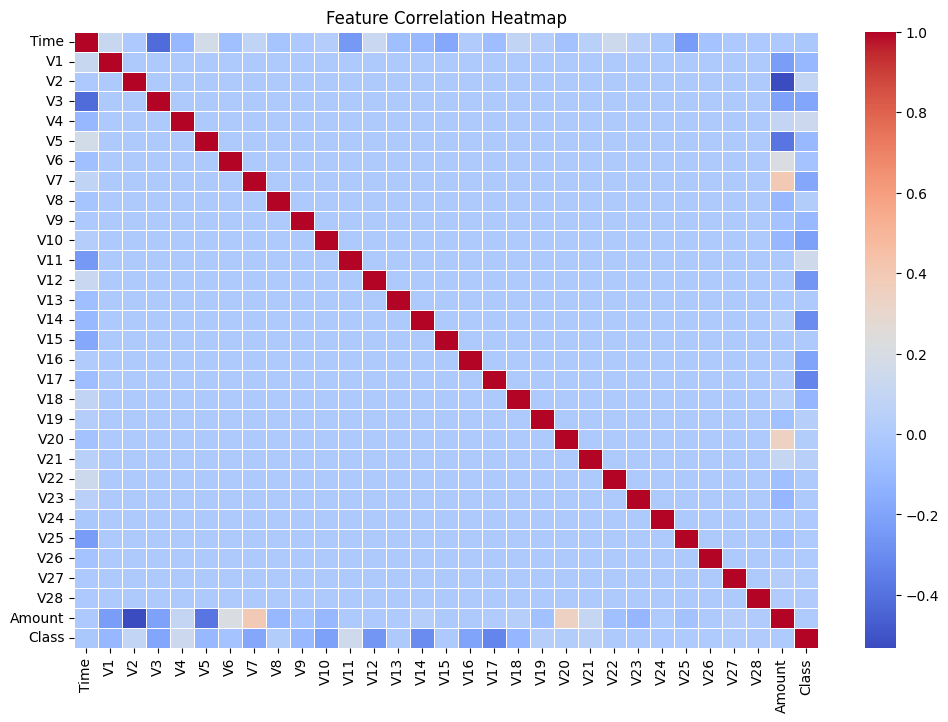

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df contains the dataset after SMOTE
# Compute the correlation matrix
corr_matrix = df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Generate a heatmap
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, fmt=".2f", linewidths=0.5)

# Add title
plt.title("Feature Correlation Heatmap")

# Show the heatmap
plt.show()

# The model

The idea of the project is to create a lower level models, if the lower level model cannot decide if it is fraud or not we will then call the higher level model which is a Q-learning model which will then double check the answer

The reinforcement learning model is the Q-learning

The Hierarchical model comes from having two levels
- The lower models which will be called first
- The higher model which will be called if 30% or more of the lower level models predict fraud



Setting up the reinforcement learning functions for use in the higher level model


In [ ]:
# Q-learning setup
# There are 2 possible actions: guessing fraud or guessing not fraud
# The number of possible states corresponds with the size of the dataset
num_possible_actions = 2
num_states = len(X_resampled)


Q_table = np.random.rand(num_states, num_possible_actions)
learning_rate = 0.1
discount_factor = 0.99
epsilon = 0.3 #decides whether to try something new or to try most optimal known action

max_episodes = 1000


#Q-learning functions

# This fucntion defines the reward for each prediction
# Takes input of the correct y_value and the predicted y_value
# +6 for true positive if fraud, +8 for true positive not fraud
# -10 false positive fraud, -9 false negative fraud
# These values were found through trial and error mostly
def reward_function(y_value, y_pred, episode):
    if y_value == y_pred:
      return 6 if y_value == 1 else 8
    else:
      return -10 if y_value == 1 else -9

# This function chooses an action for a given state
# It generates a random float between 0 and 1, if this float is less than the epsilon
# value, it chooses a random action. If the value is greater than epsilon, the function
# chooses the best known action for the state to maximize reward
def choose_action(state):
  if random.uniform(0, 1) < epsilon:
    return random.randint(0, num_possible_actions - 1)
  else:
    return np.argmax(Q_table[state])

# This function updates the Q-table with the information gained from taking a certain action
def update_q_table(state, action, reward, next_state):
  best_action = np.argmax(Q_table[next_state])
  Q_table[state, action] = Q_table[state, action] + learning_rate * (reward + discount_factor * Q_table[next_state, best_action] - Q_table[state, action])

# This function predicts an action for a given state by taking the best known action from the Q-table
# for the maximum reward value
def predict_action(state):
  return np.argmax(Q_table[state])

# Setup for evaluation metrics
highest_f1 = 0
espisodes_waited = 0
ttw = 10 # Time to wait before early stopping(waits maximum of 10*10 episodes)
f1_scores = []
epsilons = []
fraud_counts = []
nonfraud_counts = []
episodes_tracked = []

# Training loop for the Q-learning model
# Loops a maximum of 1000 episodes
# Trains on a random subset of X_resmapled every episode
# Each step is looking at one state (one element of the subset) and making a prediction
# This prediction, along with the results of the prediction like the reward (positive or negative) is the recorded in the Q-table
for episode in range(max_episodes):
  subset = np.random.choice(len(X_resampled), size=50000, replace=False)
  for step in subset:
    state = step
    action = choose_action(state)
    prediction = predict_action(state)
    correct_value = y_resampled.iloc[step]
    reward = reward_function(correct_value, prediction, episode)
    next_state = step + 1 if step + 1 < len(X_resampled) else step
    update_q_table(state, action, reward, next_state)


  # Creating checkpoints every 10 episodes to check the number of guesses for each class
  # as well as checking f1 score for early stopping purposes
  if episode % 10 == 0:
    print(f"Episode = {episode} completed")
    Q_preds = np.array([predict_action(s) for s in range(num_states)])
    f1 = f1_score(y_resampled, Q_preds)
    print(f"F1 Score = {f1:.4f}")

    # Early stopping function based on f1 score
    # If the f1 score doesn't increase for 100 episodes, the model stops
    if f1 > highest_f1:
      highest_f1 = f1
      espisodes_waited = 0
    else:
      espisodes_waited += 1
    if espisodes_waited >= ttw:
      print("Early stopping due to f1 score not increasing")
      break

    # This saves the values for number of fraud and not fraud predictions to keep track of the model during training
    # as well as for use in later evaluation
    unique, counts = np.unique(Q_preds, return_counts=True)
    count_dict = dict(zip(unique, counts))
    print(f"Not Fraud predictions = {count_dict.get(0, 0)}")
    print(f"Fraud Predictions = {count_dict.get(1, 0)}")

    # Saving f1 scores, fraud/not fraud prediction counts, and number of episodes for later use in evaluation
    f1_scores.append(f1)
    fraud_counts.append(count_dict.get(1, 0))
    nonfraud_counts.append(count_dict.get(0, 0))
    episodes_tracked.append(episode)

  # Every 100 episodes, epsilon value decays
  # This is to make the model start to converge on a "strategy" for predicting fraud/not fraud
  if ((episode % 100 == 0) & (episode != 0)):
    epsilon *= 0.9
    print(f"Epsilon = {epsilon}")

Episode = 0 completed
F1 Score = 0.0804
Not Fraud predictions = 163407
Fraud Predictions = 130908
Episode = 10 completed
F1 Score = 0.2486
Not Fraud predictions = 236554
Fraud Predictions = 57761
Episode = 20 completed
F1 Score = 0.4035
Not Fraud predictions = 258402
Fraud Predictions = 35913
Episode = 30 completed
F1 Score = 0.5263
Not Fraud predictions = 267931
Fraud Predictions = 26384
Episode = 40 completed
F1 Score = 0.6144
Not Fraud predictions = 272623
Fraud Predictions = 21692
Episode = 50 completed
F1 Score = 0.6711
Not Fraud predictions = 275107
Fraud Predictions = 19208
Episode = 60 completed
F1 Score = 0.7078
Not Fraud predictions = 276446
Fraud Predictions = 17869
Episode = 70 completed
F1 Score = 0.7294
Not Fraud predictions = 277164
Fraud Predictions = 17151
Episode = 80 completed
F1 Score = 0.7390
Not Fraud predictions = 277485
Fraud Predictions = 16830
Episode = 90 completed
F1 Score = 0.7448
Not Fraud predictions = 277664
Fraud Predictions = 16651
Episode = 100 comple

Importing everything necessary for training/testing the lower level models as well and some necessities for later setting up evaluation metrics.

Also setting up train/test splitting and retaining the indices for use in evaluating the Q-learning model later

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=42)
X_resampled_idx = np.arange(len(X_resampled))
y_resampled_idx = np.arange(len(y_resampled))
X_train_idx, X_test_idx = train_test_split(X_resampled_idx, random_state=42)
y_train_idx, y_test_idx = train_test_split(y_resampled_idx, random_state=42)

### Training the lower level models

The central idea is that we use each feature on its own to try and figure out if it fraud or a valid transaction and then if a certain amount of features say that it is fraud, we then call the higher model

One assumption is that each feature has the same relevance as each other.

In [ ]:
# Setting up the smaller decision trees for each feature
results = {}
l_preds = [] # Place to store all predictions from lower level models

# Iterating through each feature to create a decision tree for each one
for feature in X.columns:
  Xf = X_resampled[[feature]]
  Xf_train, Xf_test, yf_train, yf_test = train_test_split(Xf, y_resampled, test_size=0.2, random_state=42)

  model = DecisionTreeClassifier()
  model.fit(Xf_train, yf_train)

  y_pred = model.predict(Xf_test)
  l_preds.append(y_pred)

  # Getting and printing R^2 value for each model
  # These are all fairly high, but this is a misrepresentation due to the model
  # being able to get very high accuracy by guessing only 0 (not fraud)
  r2 = model.score(Xf_test, yf_test)
  print(f'R2 score for {feature}: {r2:.4f}')

R2 score for Time: 0.9575
R2 score for V1: 0.9471
R2 score for V2: 0.9558
R2 score for V3: 0.9677
R2 score for V4: 0.9652
R2 score for V5: 0.9508
R2 score for V6: 0.9500
R2 score for V7: 0.9617
R2 score for V8: 0.9470
R2 score for V9: 0.9613
R2 score for V10: 0.9823
R2 score for V11: 0.9773
R2 score for V12: 0.9800
R2 score for V13: 0.9378
R2 score for V14: 0.9866
R2 score for V15: 0.9365
R2 score for V16: 0.9708
R2 score for V17: 0.9826
R2 score for V18: 0.9596
R2 score for V19: 0.9409
R2 score for V20: 0.9408
R2 score for V21: 0.9492
R2 score for V22: 0.9388
R2 score for V23: 0.9392
R2 score for V24: 0.9391
R2 score for V25: 0.9390
R2 score for V26: 0.9374
R2 score for V27: 0.9471
R2 score for V28: 0.9444
R2 score for Amount: 0.9656


In [ ]:
# Setting up np array for lower level models
l_preds = np.array(l_preds)
l_guesses = np.mean(l_preds, axis=0)
l_guesses = (l_guesses >= 0.3).round().astype(int)

# Getting the indices where the majority of models
fraud_guess_indices = np.where(l_guesses == 1)[0]
print(f'Indices of fraud guesses:{fraud_guess_indices}')

# Setting up dataframe with just the rows of the above indices
df_fraud_guesses_X = X_resampled.iloc[fraud_guess_indices]
df_fraud_guesses_y = y_resampled.iloc[fraud_guess_indices]

Q_preds = [] # Place to store RL predictions
for i in fraud_guess_indices:
  state = i
  action = predict_action(state)
  Q_preds.append(action)

HL_accuracy = accuracy_score(df_fraud_guesses_y, Q_preds)
print("Number of fraud/no fraud predictions = ", np.unique(Q_preds, return_counts=True))
print(f'Accuracy for higher level model = {HL_accuracy:.4f}')

Indices of fraud guesses:[   97   167   173 ... 58626 58674 58758]
Number of fraud/no fraud predictions =  (array([0, 1]), array([1047,   24]))
Accuracy for higher level model = 0.9804


# Evaluation

Here we will evaluate or model

Note: can we get potentially a heat matrix???



Unique predictions: (array([0, 1]), array([69523,  4056]))
Class
0    71101
1     2478
Name: count, dtype: int64
Precision = 0.6065
Recall = 0.9927
F1 Score = 0.7530
Accuracy = 0.9781
Accuracy for true fraud cases = 0.9927


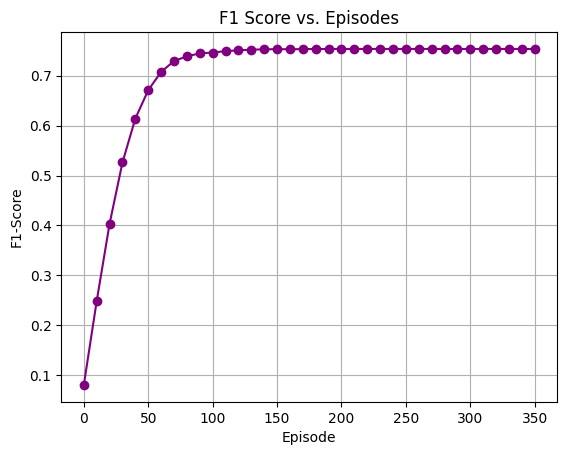

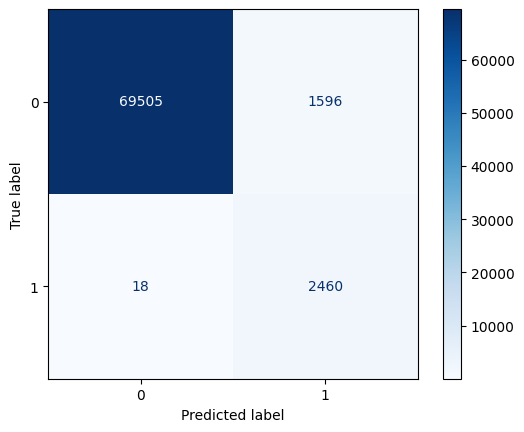

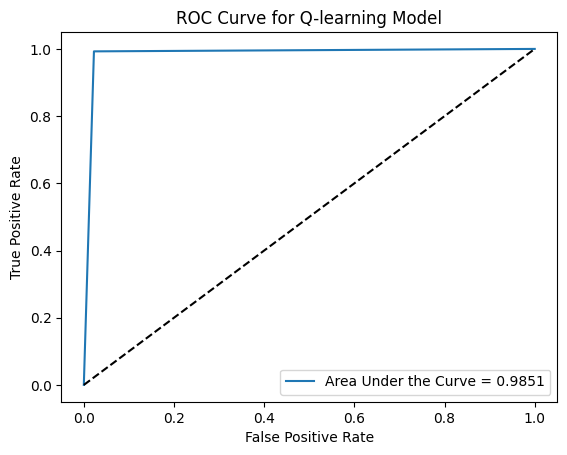

In [ ]:
# Setting up evaluation metrics
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, f1_score, recall_score, precision_score, roc_auc_score, roc_curve

Q_preds_full_rs = np.array([predict_action(s) for s in X_test_idx])
print("Unique predictions:", np.unique(Q_preds_full_rs, return_counts=True))
precision = precision_score(y_test, Q_preds_full_rs)
recall = recall_score(y_test, Q_preds_full_rs)
f1 = f1_score(y_test, Q_preds_full_rs)
accuracy = accuracy_score(y_test, Q_preds_full_rs)

print(y_test.value_counts())

print(f'Precision = {precision:.4f}')
print(f'Recall = {recall:.4f}')
print(f'F1 Score = {f1:.4f}')
print(f'Accuracy = {accuracy:.4f}')
# The accuracy of the model for predicting fraud cases is higher than the accuracy score would suggest due to false positives
# The false positives are most likely negligible in this context, as it is more important to catch every fraud case than to
# have a higher accuracy in predicting that a specific case is not fraud
print(f'Accuracy for true fraud cases = {accuracy_score(y_test[y_test == 1], Q_preds_full_rs[y_test == 1]):.4f}')

# F1-score plot
plt.plot(episodes_tracked, f1_scores, marker='o', color='purple')
plt.title("F1 Score vs. Episodes")
plt.xlabel("Episode")
plt.ylabel("F1-Score")
plt.grid(True)

# Confusion matrix
cm = confusion_matrix(y_test, Q_preds_full_rs)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()


# ROC curve with AUC
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, Q_preds_full_rs)
auc_score = roc_auc_score(y_test, Q_preds_full_rs)
plt.plot(false_positive_rate, true_positive_rate, label=f'Area Under the Curve = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Q-learning Model')
plt.legend(loc="lower right")
plt.show()